In [1]:
from utils import *

hete = Heterogeneity()
hete.check_torch_gpu()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: torchy | Python version: 3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1
Torch build with CUDA? True
# Device(s) available: 1, Name(s): Quadro P520



***
# END

In [2]:
fdir, gdir = os.path.join(hete.data_dir, 'h2dataf'), os.path.join(hete.data_dir, 'h2datag')
facies = hete.load_facies()

Facies shape: (1000, 256, 256)


In [21]:
p = np.zeros((61,256,256,1))
s = np.zeros((61,256,256,1))
for i in range(61):
    d = loadmat('//dcstorage.lanl.gov/MFR2/misael/h2dataf/1UHSS_{}'.format(i))
    p[i], s[i] = d['PRESSURE'], d['SGAS']*d['YMF_3']
    pres = MinMaxScaler().fit_transform(p.reshape(61,256*256)).reshape(61,256,256,1)
    satu = MinMaxScaler().fit_transform(s.reshape(61,256*256)).reshape(61,256,256,1)
    x = np.concatenate([pres,satu],-1)
    np.save('//dcstorage.lanl.gov/MFR2/misael/y_data/y_data_1', x)

In [23]:
temp = np.load('//dcstorage.lanl.gov/MFR2/misael/y_data/y_data_1.npy')
temp.shape

(61, 256, 256, 2)

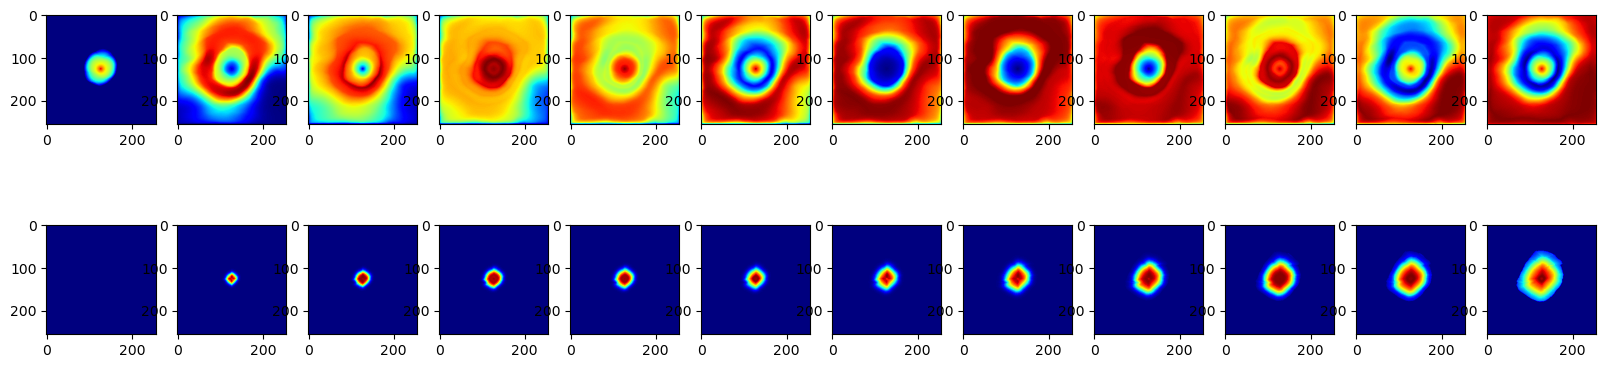

In [24]:
fig, axs = plt.subplots(2, 12, figsize=(20,5))
for i in range(2):
    for j in range(12):
        axs[i,j].imshow(temp[j*5,:,:,i], 'jet')

In [ ]:
n_realizations = 1000

X_data = np.zeros((2*n_realizations,61,256,256,4))
for i in range(n_realizations):
    t = np.load('data2D/times/time_{}.npy'.format(i))
    # Fluvial
    dataf = loadmat(fdir + '/{}UHSS_0'.format(i+1), simplify_cells=True)
    porof = np.expand_dims(dataf['PORO'],-1)
    permf = np.expand_dims(np.log10(dataf['PERMX']),-1)
    chanf = np.moveaxis(np.expand_dims(facies[i], -1).T, 0, -1)
    Xf = np.repeat(np.concatenate([porof, permf, chanf], -1)[np.newaxis,...], 61, 0)
    Xf = np.concatenate([Xf, t], -1)
    X_data[i] = Xf
    # Gaussian
    datag = loadmat(gdir + '/{}UHSS_0'.format(i+1), simplify_cells=True)
    porog = np.expand_dims(datag['PORO'],-1)
    permg = np.expand_dims(np.log10(datag['PERMX']),-1)
    angle = np.load('data2D/angles/angle_{}.npy'.format(i))
    Xg = np.repeat(np.concatenate([porog, permg, angle], -1)[np.newaxis,...], 61, 0)
    Xg = np.concatenate([Xg, t], -1)
    X_data[i+n_realizations] = Xg
print(X_data.shape)
X_data = np.moveaxis(X_data, -1, 2).reshape(2*n_realizations*61,4,256,256)
print(X_data.shape)

In [ ]:
y_data = np.zeros((2*n_realizations,61,256,256,2))
for i in range(n_realizations):
    for j in range(61):
        dataf = loadmat(fdir + '/{}UHSS_{}'.format(i+1,j), simplify_cells=True)
        datag = loadmat(gdir + '/{}UHSS_{}'.format(i+1,j), simplify_cells=True)
        y_data[i,j,:,:,0] = dataf['PRESSURE']
        y_data[i,j,:,:,1] = dataf['SGAS'] * dataf['YMF_3']  
        
        y_data[i+n_realizations,j,:,:,0] = datag['PRESSURE']
        y_data[i+n_realizations,j,:,:,1] = datag['SGAS'] * datag['YMF_3']
        
print(y_data.shape)
y_data = np.moveaxis(y_data.reshape(2*n_realizations*61,256,256,2),-1,1)
print(y_data.shape)

In [ ]:
xtemp = X_data.reshape(100,61,4,256,256)[:3].reshape(3*61,4,256,256)
ytemp = y_data

In [ ]:
device = 'cuda'

rom = h2_hete_rom().to(device)
optimizer = NAdam(rom.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_train = torch.Tensor(xtemp).to(device)
y_train = torch.Tensor(ytemp).to(device)

loss, val_loss = [], []
metrics = {'loss':[], 'val_loss':[]}
epochs = 10
batch_size = 1

for epoch in range(epochs):
    rom.train()
    epoch_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inp  = X_train[i:i+batch_size]
        true = y_train[i:i+batch_size]
        optimizer.zero_grad()
        pred = rom(inp)
        loss = loss_fn(pred,true)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*inp.size(0)
    metrics['loss'].append(epoch_loss/len(X_train))